In [110]:
its_jupyter_notebook = True
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from tqdm.notebook import tqdm
from pathlib import Path
import argparse
import math
from scipy import stats
import copy
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.insert(0, '..')

from util.evaluation import ModelResultsManager, calculate_correlations, balancing_only_for_one_task, obtain_all_model_auc, remove_outliers, map_thermodynamic_columns, obtain_df_auc, replace_outliers_with_nan_and_make_positive, obtain_sr_nosr, map_dataset_to_hp
from util.plot_utils import npv_precision, plot_sr_distributions, calc_metric, plot_tnr_based_on_distance_for_our_model, collect_results_based_on_topbottom_for_all_models, plot_results_based_on_topbottom_for_all_models, plot_results_how_many_repeats_in_pred_pos_for_all_models, plot_metric_confidence_for_all_models, plot_tnr_based_on_distance_for_all_models, plot_confidence_based_on_distance_for_all_models, plot_tnr_for_all_models, quantile_bins, plot_features_vs_risearch2_confidence, plot_heatmap, plot_tnr_recall_for_all_models, plot_correlation_nreads_prob_intsize
from util.model_names_map import map_model_names
from run_compare_models import load_results_new
#from run_compare_models import load_results_new

from config import *
from models.nt_classifier import build as build_model 
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '200_test_tables')

In [111]:
checkpoint_dir_paths = []

chkpt_folder = os.path.join(ROOT_DIR, 'checkpoints')

models_to_check = os.listdir(chkpt_folder)
for model_name in models_to_check:
    model_folder = os.path.join(chkpt_folder, model_name)
    test_paris = os.path.join(chkpt_folder, model_name, 'test_results200.csv')
    ricseq = os.path.join(chkpt_folder, model_name, 'ricseq_results200.csv')
    splash = os.path.join(chkpt_folder, model_name, 'splash_results200.csv')
    mario = os.path.join(chkpt_folder, model_name, 'mario_results200.csv')

    if os.path.exists(test_paris) & os.path.exists(ricseq) & os.path.exists(splash) & os.path.exists(mario):
        checkpoint_dir_paths.append(model_folder)

In [112]:
for i in range(1, 2):
    df, name_map = load_results_new(checkpoint_dir_paths[:i], chkpt_folder)

In [113]:
mean_aucHQ = df.filter(['auc_interactors_parisHQ', 'auc_patches_parisHQ', 'auc_interactors_ricseqHQ', 'auc_patches_ricseqHQ'], axis = 1).mean(axis = 1)

mean_tnr = df.filter(['tnr_psoralen', 'tnr_ricseq', 'tnr_paris_mouse', 'tnr_mario'], axis = 1).mean(axis = 1)
mean_prec = df.filter(['precision_psoralen', 'precision_ricseq', 'precision_paris_mouse', 'precision_mario'], axis = 1).mean(axis = 1)
mean_recall = df.filter(['recall_psoralen', 'recall_ricseq', 'recall_paris_mouse', 'recall_mario'], axis = 1).mean(axis = 1)

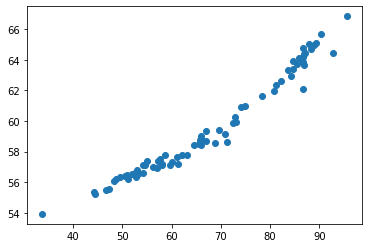

In [114]:
plt.scatter(mean_tnr, mean_prec)

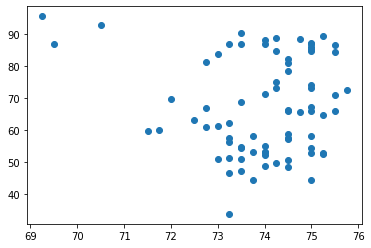

In [115]:
plt.scatter(mean_aucHQ, mean_tnr)

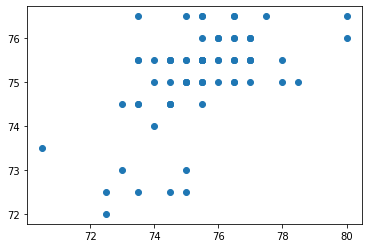

In [116]:
mean_aucvalHQ = df.filter(['auc_interactors_val_HQ', 'auc_patches_val_HQ'], axis = 1).mean(axis = 1)
mean_auctestHQ = df.filter(['auc_interactors_parisHQ', 'auc_patches_parisHQ'], axis = 1).mean(axis = 1)
plt.scatter(mean_aucvalHQ, mean_auctestHQ)

In [117]:
MIN_TNR = 70
MIN_AUC = 75

best_models = df[
    (mean_tnr >= MIN_TNR) &
    (mean_aucHQ >= MIN_AUC)
]

In [118]:
best_models.filter([
    'auc_interactors_parisHQ', 'auc_patches_parisHQ', 
    'auc_interactors_paris_mouse_HQ', 'auc_patches_paris_mouse_HQ',
    'auc_interactors_ricseqHQ', 'auc_patches_ricseqHQ'
], axis = 1)

,auc_interactors_parisHQ,auc_patches_parisHQ,auc_interactors_paris_mouse_HQ,auc_patches_paris_mouse_HQ,auc_interactors_ricseqHQ,auc_patches_ricseqHQ
6,74.0,79.0,62.0,77.0,72.0,78.0
46,72.0,79.0,62.0,77.0,71.0,78.0
47,72.0,79.0,59.0,74.0,71.0,78.0
50,73.0,79.0,61.0,75.0,70.0,78.0
53,72.0,79.0,62.0,77.0,71.0,78.0
56,72.0,79.0,61.0,76.0,71.0,78.0
58,73.0,79.0,61.0,75.0,70.0,78.0
59,73.0,80.0,59.0,75.0,71.0,78.0
62,72.0,79.0,60.0,75.0,71.0,78.0
66,73.0,80.0,60.0,76.0,71.0,78.0


In [119]:
for _, row in best_models.iterrows():
    print(_, name_map[row.model])

6 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0057
46 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0056
47 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0063
50 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0030
53 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0043
56 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0052
58 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0062
59 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0066
62 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweigh

# Best model in the same training

In [120]:
def extract_last_digits(text):
    # Search for the last number pattern at the end of the string
    match = re.search(r'(\d+)(?!.*\d)', text)
    return match.group(1) if match else None

def plot_auc_metrics(df, best_epoch = 9999, epoch_col='epoch', series_dict=None, title='AUC Metrics Over Epochs', xlabel='Epoch', ylabel='AUC'):
    """
    Plots AUC metrics over epochs for multiple series.

    Parameters:
        df (pd.DataFrame): Dataframe containing the data.
        epoch_col (str): Name of the epoch column in df.
        series_dict (dict): Dictionary where keys are labels and values are tuples 
                            with (column names in df, color, line style).
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    """
    if series_dict is None:
        raise ValueError("Please provide a series_dict with labels and columns to plot.")

    # Plotting
    plt.figure(figsize=(10, 6))
    
    for label, (columns, color, linestyle) in series_dict.items():
        # Calculate average if multiple columns provided
        series_data = df[columns].mean(axis=1) if len(columns) > 1 else df[columns[0]]
        plt.plot(df[epoch_col], series_data, color=color, linestyle=linestyle, label=label, marker='o')

        
    if best_epoch < 999:
        plt.axvline(x=best_epoch, label = 'best')
    # Customize plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
def find_best_epoch(df, columns_to_mean, n_epoch_early_stopping=10, minimize=False):
    
    series = df.filter(columns_to_mean, axis=1).mean(axis=1)
    if minimize:
        series = -series

    # Early stopping logica
    best = float('-inf')  # Per massimizzare
    best_epoch = 0
    iteration_best = 0

    for i, value in enumerate(series):
        if value > best:
            best = value
            best_epoch = df.loc[i].epoch #le epoche partono da 1 non da zero nel dataframe
            iteration_best = 0  # Reset del contatore
        else:
            iteration_best += 1

        if iteration_best >= (n_epoch_early_stopping-1):
            break
    
    return best_epoch


In [121]:
folder_name = 'arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest' #'arch2_PSORALENtrained_PARISval' #'arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest' 

folders = []

checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', folder_name)

# List of files
files = os.listdir(checkpoint_dir)

# Dictionary to store filenames and their values
desired_files = {}

# Regular expression pattern to extract numbers or 'BEST'
pattern = re.compile(r'checkpoint(\d+).pth|checkpointBEST.pth')

for file in files:
    match = pattern.match(file)
    if match:
        value = match.group(1) if match.group(1) else 'BEST'
        desired_files[file] = value

for i in desired_files.keys():
    ckpt_folder = checkpoint_dir+desired_files[i]
    folders.append(os.path.basename(ckpt_folder))

In [122]:
names_df = pd.DataFrame.from_dict(name_map, 'index').reset_index().rename({0:'model_path_folder', 'index':'model_name'}, axis = 1)
names_df

,model_name,model_path_folder
0,model0,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
1,model1,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
2,model2,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
3,model3,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
4,model4,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
...,...,...
72,model72,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
73,model73,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
74,model74,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
75,model75,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...


In [123]:
# Log 
# from util.plot_utils import plot_logs
# if os.path.isfile(os.path.join(checkpoint_dir, 'log.txt')):
#     log = pd.read_json(Path(os.path.join(checkpoint_dir, 'log.txt')), lines=True)
#     best_model = log.iloc[np.argmin(log.test_loss)].epoch
#     print(best_model)
#     for metric in ['loss', 'accuracy']:
#         plot_logs(log, metric, best_model = best_model)

### Other criteria

In [124]:
names_df = pd.DataFrame.from_dict(name_map, 'index').reset_index().rename({0:'model_path_folder', 'index':'model_name'}, axis = 1)

rows = []
for folder in folders:
    model_path_folder=os.path.join(chkpt_folder, folder)
    names_df_row = names_df[names_df.model_path_folder == model_path_folder]
    if names_df_row.shape[0]>0:
        names_df_row = names_df_row.iloc[0]
        rows.append({
            'original_model_name':folder,
            'model':names_df_row.model_name,
            'epoch':int(extract_last_digits(folder)),
            'model_path_folder':model_path_folder,
            })
    
training = pd.DataFrame(rows).sort_values('epoch', ascending = True).reset_index(drop = True)

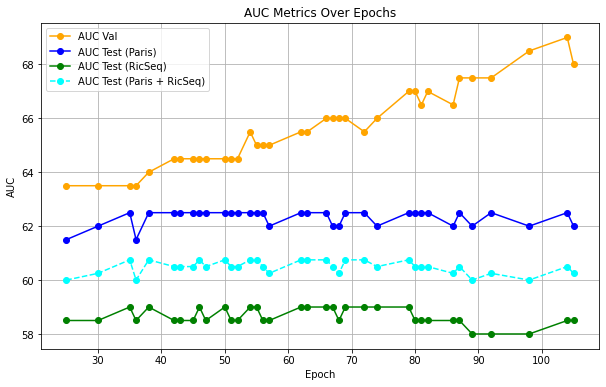

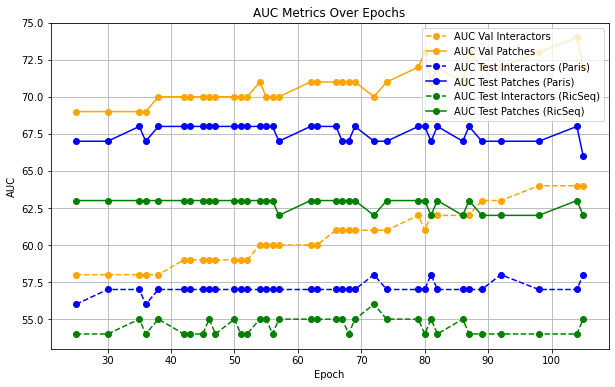

In [125]:
df_plot = training.merge(df[['model','auc_interactors_val', 'auc_patches_val', 'auc_interactors_paris', 'auc_patches_paris', 'auc_interactors_ricseq', 'auc_patches_ricseq']], on ='model')


# Define series with colors and styles
series_dict = {
    'AUC Val': (['auc_interactors_val', 'auc_patches_val'], 'orange', '-'),
    'AUC Test (Paris)': (['auc_interactors_paris', 'auc_patches_paris'], 'blue', '-'),
    'AUC Test (RicSeq)': (['auc_interactors_ricseq', 'auc_patches_ricseq'], 'green', '-'),
    'AUC Test (Paris + RicSeq)': (['auc_interactors_ricseq', 'auc_patches_ricseq', 'auc_interactors_paris', 'auc_patches_paris'], 'cyan', '--'),
}

# Call the plotting function
plot_auc_metrics(df_plot, series_dict=series_dict)

series_dict = {
    'AUC Val Interactors': (['auc_interactors_val'], 'orange', '--'),
    'AUC Val Patches': (['auc_patches_val'], 'orange', '-'),
    'AUC Test Interactors (Paris)': (['auc_interactors_paris'], 'blue', '--'),
    'AUC Test Patches (Paris)': (['auc_patches_paris'], 'blue', '-'),
    'AUC Test Interactors (RicSeq)': (['auc_interactors_ricseq'], 'green', '--'),
    'AUC Test Patches (RicSeq)': (['auc_patches_ricseq'], 'green', '-'),
}

# Call the plotting function
plot_auc_metrics(df_plot, series_dict=series_dict)

In [126]:
find_best_epoch(df_plot, ['auc_interactors_paris', 'auc_patches_paris'], n_epoch_early_stopping=100, minimize = False)


35

best_epoch: 30


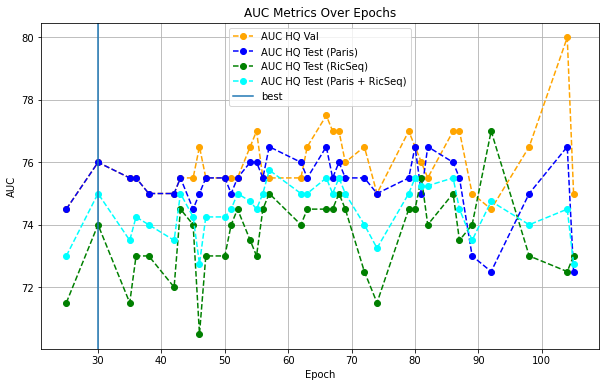

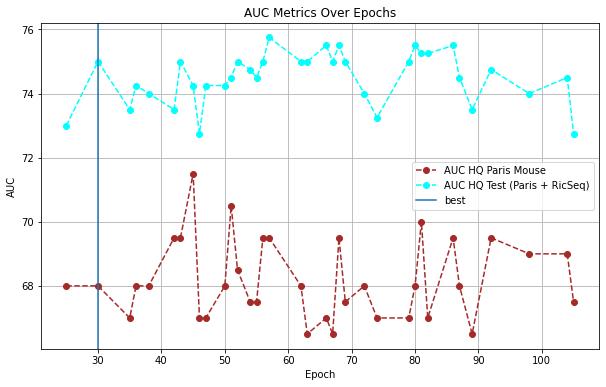

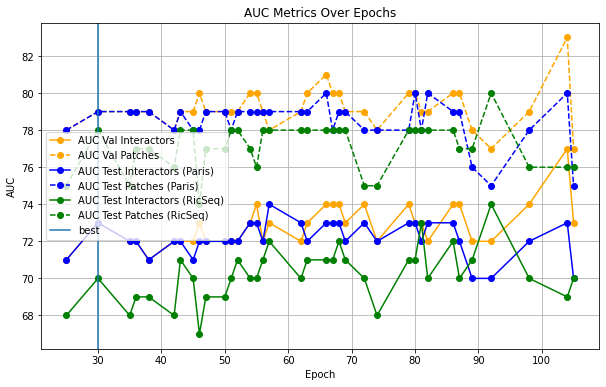

In [127]:
df_plot = training.merge(df[['model','auc_interactors_val_HQ', 'auc_patches_val_HQ', 'auc_interactors_parisHQ', 'auc_patches_parisHQ', 'auc_interactors_ricseqHQ', 'auc_patches_ricseqHQ', 'auc_interactors_paris_mouse_HQ', 'auc_patches_paris_mouse_HQ']], on ='model')

best_epoch = find_best_epoch(df_plot, ['auc_interactors_parisHQ', 'auc_patches_parisHQ', 'auc_interactors_ricseqHQ', 'auc_patches_ricseqHQ'], n_epoch_early_stopping=15)

#best_epoch = df_plot.loc[df_plot.filter(['auc_interactors_parisHQ', 'auc_patches_parisHQ', 'auc_interactors_ricseqHQ', 'auc_patches_ricseqHQ'], axis = 1).mean(axis = 1).argmax()].epoch
print(f'best_epoch: {best_epoch}')

# Define series with colors and styles
series_dict = {
    'AUC HQ Val': (['auc_interactors_val_HQ', 'auc_patches_val_HQ'], 'orange', '--'),
    'AUC HQ Test (Paris)': (['auc_interactors_parisHQ', 'auc_patches_parisHQ'], 'blue', '--'),
    'AUC HQ Test (RicSeq)': (['auc_interactors_ricseqHQ', 'auc_patches_ricseqHQ'], 'green', '--'),
    'AUC HQ Test (Paris + RicSeq)': (['auc_interactors_parisHQ', 'auc_patches_parisHQ', 'auc_interactors_ricseqHQ', 'auc_patches_ricseqHQ'], 'cyan', '--'),
}

# Call the plotting function
plot_auc_metrics(df_plot, series_dict=series_dict, best_epoch = best_epoch)


# Define series with colors and styles
series_dict = {
    'AUC HQ Paris Mouse': (['auc_interactors_paris_mouse_HQ', 'auc_patches_paris_mouse_HQ'], 'brown', '--'),
    'AUC HQ Test (Paris + RicSeq)': (['auc_interactors_parisHQ', 'auc_patches_parisHQ', 'auc_interactors_ricseqHQ', 'auc_patches_ricseqHQ'], 'cyan', '--'),
}

# Call the plotting function
plot_auc_metrics(df_plot, series_dict=series_dict, best_epoch = best_epoch)


series_dict = {
    'AUC Val Interactors': (['auc_interactors_val_HQ'], 'orange', '-'),
    'AUC Val Patches': (['auc_patches_val_HQ'], 'orange', '--'),
    'AUC Test Interactors (Paris)': (['auc_interactors_parisHQ'], 'blue', '-'),
    'AUC Test Patches (Paris)': (['auc_patches_parisHQ'], 'blue', '--'),
    'AUC Test Interactors (RicSeq)': (['auc_interactors_ricseqHQ'], 'green', '-'),
    'AUC Test Patches (RicSeq)': (['auc_patches_ricseqHQ'], 'green', '--'),
}

# Call the plotting function
plot_auc_metrics(df_plot, series_dict=series_dict, best_epoch = best_epoch)

In [128]:
find_best_epoch(df_plot, ['auc_interactors_parisHQ', 'auc_patches_parisHQ'], n_epoch_early_stopping=100, minimize = False)


57

#### Cross Entropy
NB: The loss should be divided by 100 

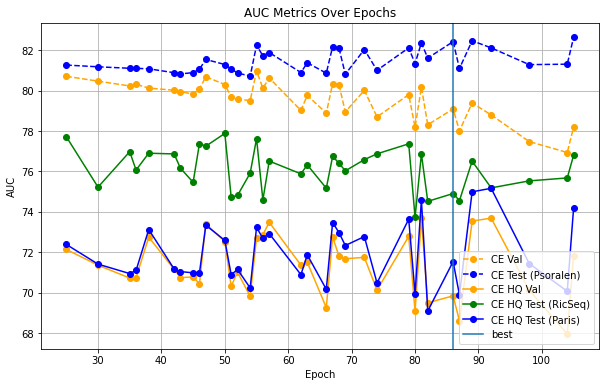

In [147]:
ce_string = 'ceFP' #ce, ceFN, ceFP

df_plot = training.merge(df[['model',f'{ce_string}_psoralen_val', f'{ce_string}_psoralen', f'{ce_string}_parisHQ', f'{ce_string}_val_HQ', f'{ce_string}_ricseqHQ']], on ='model')

# Define series with colors and styles
series_dict = {
    'CE Val': ([f'{ce_string}_psoralen_val'], 'orange', '--'),
    'CE Test (Psoralen)': ([f'{ce_string}_psoralen'], 'blue', '--'),
    'CE HQ Val': ([f'{ce_string}_val_HQ'], 'orange', '-'),
    'CE HQ Test (RicSeq)': ([f'{ce_string}_ricseqHQ'], 'green', '-'),
    'CE HQ Test (Paris)': ([f'{ce_string}_parisHQ'], 'blue', '-'),
}

# Call the plotting function
plot_auc_metrics(df_plot, series_dict=series_dict, best_epoch = 86)

In [148]:
find_best_epoch(df_plot, [f'{ce_string}_parisHQ'], n_epoch_early_stopping=30, minimize = True)

82

In [131]:
find_best_epoch(df_plot, [f'{ce_string}_psoralen'], n_epoch_early_stopping=30, minimize = True)

54

In [132]:
best_epoch = df_plot.loc[df_plot.filter([f'{ce_string}_psoralen_val'], axis = 1).mean(axis = 1).argmin()].epoch

best_model = df_plot[df_plot.epoch == best_epoch].original_model_name.iloc[0]
best_model, find_best_epoch(df_plot, [f'{ce_string}_psoralen_val'], n_epoch_early_stopping=50, minimize = True), find_best_epoch(df_plot, [f'{ce_string}_val_HQ'], n_epoch_early_stopping=50, minimize = True), 


('arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0104',
 104,
 104)

In [133]:
best_epoch = df_plot.loc[df_plot.filter([f'{ce_string}_parisHQ', f'{ce_string}_ricseqHQ'], axis = 1).mean(axis = 1).argmin()].epoch

best_model = df_plot[df_plot.epoch == best_epoch].original_model_name.iloc[0]
best_model, find_best_epoch(df_plot, [f'{ce_string}_parisHQ', f'{ce_string}_ricseqHQ'], n_epoch_early_stopping=20, minimize = True)

('arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0082', 82)

#### Fscore

92


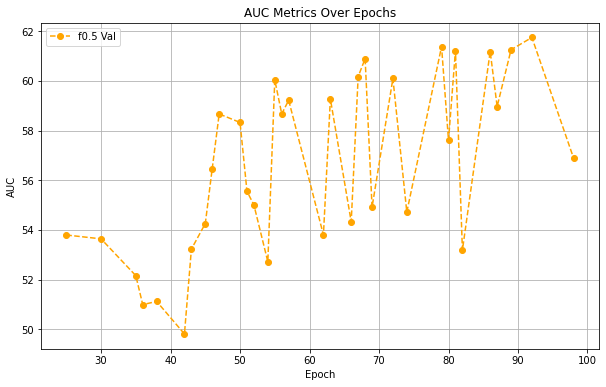

In [134]:
beta = 0.5
limit_epoch = 100

df_plot = training.merge(df[['model','precision_val', 'recall_val']], on ='model')

df_plot['fscore_val'] = (1 + beta**2) * (df_plot['precision_val'] * df_plot['recall_val']) / \
                        (beta**2 * df_plot['precision_val'] + df_plot['recall_val']).replace(0, np.nan)

# Define series with colors and styles
series_dict = {
    f'f{beta} Val': (['fscore_val'], 'orange', '--'),
}

df_plot = df_plot[df_plot.epoch <= limit_epoch]

best_epoch = df_plot.loc[df_plot.filter(['fscore_val'], axis = 1).mean(axis = 1).argmax()].epoch
print(best_epoch)

# Call the plotting function
plot_auc_metrics(df_plot, series_dict=series_dict)

81


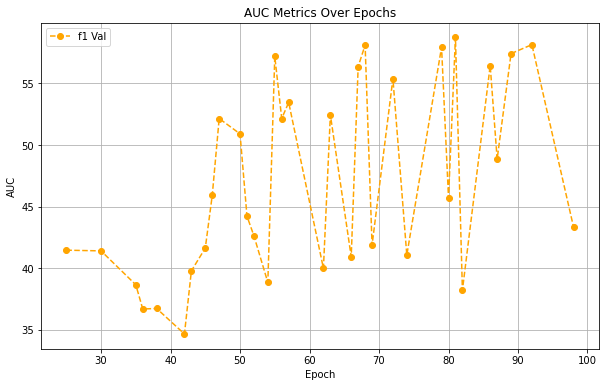

In [135]:
beta = 1
limit_epoch = 100

df_plot = training.merge(df[['model','precision_val', 'recall_val']], on ='model')

df_plot['fscore_val'] = (1 + beta**2) * (df_plot['precision_val'] * df_plot['recall_val']) / \
                        (beta**2 * df_plot['precision_val'] + df_plot['recall_val']).replace(0, np.nan)

# Define series with colors and styles
series_dict = {
    f'f{beta} Val': (['fscore_val'], 'orange', '--'),
}

df_plot = df_plot[df_plot.epoch <= limit_epoch]

best_epoch = df_plot.loc[df_plot.filter(['fscore_val'], axis = 1).mean(axis = 1).argmax()].epoch
print(best_epoch)

# Call the plotting function
plot_auc_metrics(df_plot, series_dict=series_dict)

86


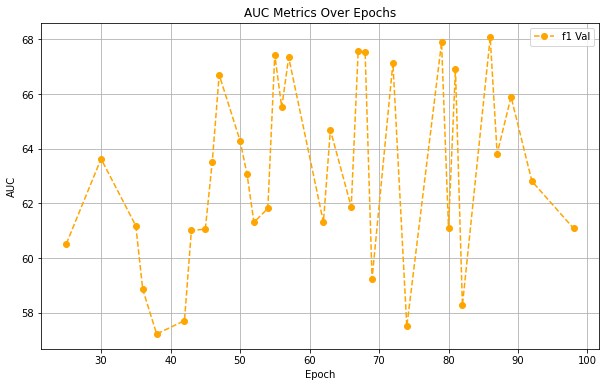

In [140]:
beta = 1
limit_epoch = 100

df_plot = training.merge(df[['model','precision_parisHQ', 'recall_parisHQ']], on ='model')

df_plot['fscore'] = (1 + beta**2) * (df_plot['precision_parisHQ'] * df_plot['recall_parisHQ']) / \
                        (beta**2 * df_plot['precision_parisHQ'] + df_plot['recall_parisHQ']).replace(0, np.nan)

# Define series with colors and styles
series_dict = {
    f'f{beta} Val': (['fscore'], 'orange', '--'),
}

df_plot = df_plot[df_plot.epoch <= limit_epoch]

best_epoch = df_plot.loc[df_plot.filter(['fscore'], axis = 1).mean(axis = 1).argmax()].epoch
print(best_epoch)

# Call the plotting function
plot_auc_metrics(df_plot, series_dict=series_dict)